In [11]:
# =====================================================
# 📘 IMPORT LIBRARY
# =====================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, roc_curve,
    classification_report, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

1. Library Dasar untuk data
* Pandas (pd), digunakan
untuk membaca dan mengolah data dalam bentuk DataFrame.
* numpy (np) digunakan untuk operasi numerik, komputasi matematika, dan manipulasi array.

2. Viasualisasi Data
* matplotlib.pyplot (plt),
untuk membuat grafik dasar seperti histogram, scatter plot, dan line plot.
* seaborn(sns), library visualisasi tingkat lanjut yang membuat grafik lebih informatif dan estetik.

3. Model Selection & Preprocessing (Scikit-Learn)
* Train_tes_split, untuk membagi dataset menjadi data latih dan data uji.
* RandomizedSearchCV, untuk pencarian hyperparameter menggunakan sampling acak.
* StratifiedKfold-cross validation dengan menjaga proporsi kelas.
* Cross_val_score-menghitung skor model menggunakan cross-validation
* standarScaler, untuk menstandarkan fitur (mean=0, std=1), penting untuk model sensitif skala

4. Evaluasi Model
Digunakan untuk mengukur performa model klasifikasi:
* confusion_matrix untuk menunjukkan prediksi benar dan salah.
* roc_auc_score & roc_curve untuk menilai performa model melalui kurva ROC dan nilai AUC.
* classification_report untuk menampilkan precision, recall, dan f1-score.
* accuracy_score precision_score, recall_score, f1_score sebagai metrik evaluasi terperinci.

5. Model Machine Learning
* RandomForestClassifier untuk model ensemble berbasis bagging menggunakan banyak decision tree.
* GradientBoostingClassifier untuk model boosting yang meningkatkan akurasi secara bertahap.
* VotingClassifier untuk menggabungkan beberapa model menjadi satu model ensemble.

6. Handling Imbalance Data
* SMOTE, merupakan
Teknik oversampling untuk menyeimbangkan kelas dengan membuat sampel sintetis pada kelas minoritas.

7. XGBoost
* XGBClassifier merupakan
Model gradient boosting yang sangat kuat dan populer untuk data tabular.
Dikenal dengan performa tinggi, efisiensi komputasi, dan akurasi yang bagus.

In [12]:
# =====================================================
#  1. BACA DATA
# =====================================================
train = pd.read_csv('/content/data_training.csv')
test = pd.read_csv('/content/data_testing.csv')

print("Data training:", train.shape)
print("Data testing:", test.shape)
print(train.head())

Data training: (857, 13)
Data testing: (286, 12)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.3             0.740         0.08             1.7      0.094   
1            8.1             0.575         0.22             2.1      0.077   
2           10.1             0.430         0.40             2.6      0.092   
3           12.9             0.500         0.55             2.8      0.072   
4            8.4             0.360         0.32             2.2      0.081   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 10.0                  45.0  0.99576  3.24       0.50   
1                 12.0                  65.0  0.99670  3.29       0.51   
2                 13.0                  52.0  0.99834  3.22       0.64   
3                  7.0                  24.0  1.00012  3.09       0.68   
4                 32.0                  79.0  0.99640  3.30       0.72   

   alcohol  quality    Id  
0      9.

1. pd.read_csv()
Digunakan untuk membaca file dataset berformat .csv.
* train untuk dataset yang digunakan untuk melatih model
* test untuk dataset yang digunakan untuk evaluasi akhir atau prediksi

* train = pd.read_csv('/content/data_training.csv')

- test = pd.read_csv('/content/data_testing.csv')

2. Melihat Ukuran dataset dengan kode python
* print("Data training:", train.shape)

* print("Data testing:", test.shape)
shape menampilkan ukuran data dalam format (jumlah_baris, jumlah_kolom)
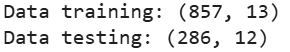

3. Melihat 5 Data Pertama dengan kode
- print(train.head())
menampilkan 5 baris pertama untuk mendapatkan gambaran struktur dataset, seperti nama kolom, tipe data, missing value, dan label target.

In [13]:
# =====================================================
#  2. PEMBERSIHAN DATA
# =====================================================
print("\nCek Missing Values:")
print(train.isnull().sum())

# Memisahkan Fitur (X) dan Target (Y)
X = train.drop(['Id', 'quality'], axis=1)
y = train['quality']

# Hapus kolom dengan hanya 1 nilai unik
constant_features = [col for col in X.columns if X[col].nunique() == 1]
X.drop(columns=constant_features, inplace=True)

# Hapus fitur dengan korelasi tinggi (>0.9)
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.9)]
X.drop(columns=high_corr_features, inplace=True)

print("Fitur dihapus:", constant_features + high_corr_features)

X_test = test.drop(['Id'], axis=1)
X_test.drop(columns=[col for col in constant_features + high_corr_features if col in X_test.columns],
            inplace=True, errors='ignore')



Cek Missing Values:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Id                      0
dtype: int64
Fitur dihapus: []


Bagian ini bertujuan untuk memastikan data bersih, tidak memiliki error, dan siap digunakan untuk proses modeling. Langkah-langkah pembersihan meliputi pengecekan missing value, menghapus fitur tidak berguna, dan mengurangi fitur yang terlalu berhubungan (high correlation).

In [14]:
# =====================================================
#  3. FEATURE ENGINEERING TAMBAHAN
# =====================================================
def add_features(df):
    if all(f in df.columns for f in ['fixed acidity', 'volatile acidity']):
        df['acidity_ratio'] = df['fixed acidity'] / (df['volatile acidity'] + 1e-6)
    if all(f in df.columns for f in ['density', 'alcohol']):
        df['density_alcohol_ratio'] = df['density'] / (df['alcohol'] + 1e-6)
    if all(f in df.columns for f in ['fixed acidity', 'citric acid', 'volatile acidity']):
        df['total_acidity'] = df['fixed acidity'] + df['citric acid'] + df['volatile acidity']
    if all(f in df.columns for f in ['free sulfur dioxide', 'total sulfur dioxide']):
        df['sulfur_ratio'] = df['free sulfur dioxide'] / (df['total sulfur dioxide'] + 1e-6)
    if 'volatile acidity' in df.columns and 'alcohol' in df.columns:
        df['acid_alcohol_interaction'] = df['volatile acidity'] * df['alcohol']
    if 'density' in df.columns:
        df['density_squared'] = df['density'] ** 2
    return df

# Terapkan pada X dan X_test
X = add_features(X)
X_test = add_features(X_test)

# =====================================================
# Tampilkan hasil feature engineering
# =====================================================

# Daftar kolom baru yang ditambahkan
new_features = [
    'acidity_ratio', 'density_alcohol_ratio', 'total_acidity',
    'sulfur_ratio', 'acid_alcohol_interaction', 'density_squared'
]

available_new_features = [f for f in new_features if f in X.columns]

print("=== FEATURE BARU YANG BERHASIL DITAMBAHKAN ===")
print(available_new_features)

print("\n=== 5 Data Pertama Setelah Penambahan Fitur ===")
print(X[available_new_features].head())

print("\n=== Statistik Ringkas Feature Baru ===")
print(X[available_new_features].describe())


=== FEATURE BARU YANG BERHASIL DITAMBAHKAN ===
['acidity_ratio', 'density_alcohol_ratio', 'total_acidity', 'sulfur_ratio', 'acid_alcohol_interaction', 'density_squared']

=== 5 Data Pertama Setelah Penambahan Fitur ===
   acidity_ratio  density_alcohol_ratio  total_acidity  sulfur_ratio  \
0       9.864852               0.101608          8.120      0.222222   
1      14.086932               0.108337          8.895      0.184615   
2      23.488317               0.099834         10.930      0.250000   
3      25.799948               0.091754         13.950      0.291667   
4      23.333269               0.090582          9.080      0.405063   

   acid_alcohol_interaction  density_squared  
0                     7.252         0.991538  
1                     5.290         0.993411  
2                     4.300         0.996683  
3                     5.450         1.000240  
4                     3.960         0.992813  

=== Statistik Ringkas Feature Baru ===
       acidity_ratio  dens

- Fungsi add_features() menambahkan 6 fitur baru berdasarkan kombinasi variabel kimia.

- Rasio, interaksi, dan transformasi non-linear digunakan untuk memperkaya informasi dalam dataset.

- Dataset training dan testing diberikan fitur tambahan yang sama untuk menjaga konsistensi.

- Feature engineering diharapkan meningkatkan performa model dalam memprediksi kualitas wine.


In [15]:
# =====================================================
# 4. STANDARISASI DATA
# =====================================================
scaler = StandardScaler() #Fungsi ini akan mengubah setiap fitur agar memiliki rata-rata (mean) = 0
                          #dan simpangan baku (standar deviasi) = 1.

# Fit & transform data training
X_scaled = scaler.fit_transform(X)

# Transform data testing
X_test_scaled = scaler.transform(X_test)

# =====================================================
# Menampilkan hasil standarisasi
# =====================================================

# Ubah menjadi DataFrame agar lebih mudah dibaca
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("=== 5 Data Pertama Setelah Standardisasi ===") #Menampilkan 5 baris pertama setelah distandarisasi
print(X_scaled_df.head())

print("\n=== Statistik Data Setelah Standardisasi ===") #Menampilkan statistik deskriptif dari data yang sudah distandarisasi.
print(X_scaled_df.describe())


=== 5 Data Pertama Setelah Standardisasi ===
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.565527          1.176198    -0.960627       -0.623616   0.147259   
1      -0.095215          0.254705    -0.242789       -0.314200  -0.201873   
2       1.080565         -0.555092     0.680145        0.072570   0.106185   
3       2.726657         -0.164156     1.449257        0.227278  -0.304559   
4       0.081152         -0.946029     0.269952       -0.236846  -0.119725   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -0.561759             -0.030890 -0.490363 -0.480901  -0.936887   
1            -0.367478              0.600550  0.004342 -0.151932  -0.877102   
2            -0.270338              0.190114  0.867443 -0.612489  -0.099897   
3            -0.853180             -0.693903  1.804225 -1.467809   0.139242   
4             1.575327              1.042558 -0.153543 -0.086138   0.378382   

    alcohol

Standarisasi (Standardization) adalah proses mengubah skala setiap fitur agar memiliki mean = 0 dan standard deviation = 1.
Langkah ini penting khususnya untuk model-model yang sensitif terhadap perbedaan skala fitur.

In [16]:
# =====================================================
#  5. PEMBAGIAN DATA TRAIN & VALIDASI
# =====================================================
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# =====================================================
# Menampilkan informasi hasil splitting
# =====================================================

print("=== Ukuran Dataset Setelah Split ===")
print(f"X_train : {X_train.shape}")
print(f"X_val   : {X_val.shape}")
print(f"y_train : {y_train.shape}")
print(f"y_val   : {y_val.shape}")

# Cek distribusi kelas untuk memastikan stratify benar
print("\n=== Distribusi Kelas Sebelum Split ===")
print(y.value_counts(normalize=True))

print("\n=== Distribusi Kelas Setelah Split ===")
print("y_train:")
print(y_train.value_counts(normalize=True))
print("\ny_val:")
print(y_val.value_counts(normalize=True))

# Tampilkan beberapa data awal
print("\n=== 5 Data Pertama X_train ===")
print(pd.DataFrame(X_train).head())

print("\n=== 5 Data Pertama X_val ===")
print(pd.DataFrame(X_val).head())


=== Ukuran Dataset Setelah Split ===
X_train : (685, 17)
X_val   : (172, 17)
y_train : (685,)
y_val   : (172,)

=== Distribusi Kelas Sebelum Split ===
quality
5    0.422404
6    0.397900
7    0.127188
4    0.030338
8    0.015169
3    0.007001
Name: proportion, dtype: float64

=== Distribusi Kelas Setelah Split ===
y_train:
quality
5    0.421898
6    0.398540
7    0.127007
4    0.030657
8    0.014599
3    0.007299
Name: proportion, dtype: float64

y_val:
quality
5    0.424419
6    0.395349
7    0.127907
4    0.029070
8    0.017442
3    0.005814
Name: proportion, dtype: float64

=== 5 Data Pertama X_train ===
         0         1         2         3         4         5         6   \
0  0.433886  1.427515 -0.140241 -0.623616 -0.181336 -0.561759 -0.788619   
1 -0.624316  1.092426 -1.114450  1.658328 -0.017038 -1.144600 -1.104339   
2 -0.330371 -0.220004 -0.037693 -0.468908 -0.509932 -0.658899 -0.472899   
3 -0.154004 -0.834333  0.885242 -0.468908  0.229408 -0.950320 -0.978051   
4 -0.50673

Proses standardisasi mengubah data menjadi skala yang sama (rata-rata 0 dan deviasi standar 1) agar model seperti Random Forest dan Gradient Boosting bekerja lebih optimal.

In [17]:
# =====================================================
#  6. SMOTE (HANYA UNTUK TRAINING)
# =====================================================
print("\nDistribusi kelas sebelum SMOTE:")
print(y_train.value_counts())

sm = SMOTE(random_state=42, k_neighbors=3)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("\nDistribusi kelas setelah SMOTE:")
print(y_train_res.value_counts())


Distribusi kelas sebelum SMOTE:
quality
5    289
6    273
7     87
4     21
8     10
3      5
Name: count, dtype: int64

Distribusi kelas setelah SMOTE:
quality
5    289
6    289
7    289
4    289
8    289
3    289
Name: count, dtype: int64


 - SMOTE (Synthetic Minority Oversampling Technique) dilakukan untuk menyeimbangkan distribusi kelas agar model tidak bias terhadap kelas mayoritas. SMOTE hanya diterapkan pada data training, bukan testing, agar tidak menyebabkan data leakage (kebocoran informasi).

- Parameter k_neighbors bisa memengaruhi hasil jika terlalu kecil dapat membuat variasi sintetis kurang, terlalu besar bisa membuat data campur antara kelas.

In [18]:
# =====================================================
#  7. RANDOMIZED SEARCH UNTUK RANDOM FOREST
# =====================================================
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample']
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=25,
    cv=5,
    n_jobs=-1,
    scoring='f1_macro',
    verbose=2,
    random_state=42
)

random_search.fit(X_train_res, y_train_res)
print("\nParameter terbaik Random Forest:")
print(random_search.best_params_)

best_rf = random_search.best_estimator_


Fitting 5 folds for each of 25 candidates, totalling 125 fits

Parameter terbaik Random Forest:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced', 'bootstrap': False}


Tahap ini bertujuan untuk melakukan pencarian parameter terbaik pada model **Random Forest** menggunakan metode **Randomized Search Cross Validation (RandomizedSearchCV)** agar performa model menjadi lebih optimal. Pada bagian ini, terlebih dahulu ditentukan ruang parameter atau *parameter grid* yang berisi berbagai kemungkinan nilai untuk setiap parameter penting dalam model, seperti jumlah pohon dalam hutan (*n_estimators*), kedalaman maksimum pohon (*max_depth*), jumlah minimum sampel untuk melakukan pemisahan (*min_samples_split*), serta jumlah minimum sampel pada daun akhir (*min_samples_leaf*). Selain itu, juga diatur parameter lain seperti jumlah fitur yang digunakan saat pemisahan (*max_features*), penggunaan metode *bootstrap*, dan pengaturan bobot kelas (*class_weight*) untuk menangani data yang tidak seimbang.

Selanjutnya, metode **RandomizedSearchCV** digunakan untuk mencoba beberapa kombinasi parameter secara acak (dalam hal ini sebanyak 25 kombinasi) dengan melakukan evaluasi menggunakan **5-fold cross-validation** dan metrik **F1-macro** sebagai ukuran performa. Metrik F1-macro dipilih karena mampu memberikan penilaian yang adil terhadap data dengan jumlah kelas yang tidak seimbang, dengan mempertimbangkan keseimbangan antara presisi dan recall untuk setiap kelas. Setelah proses pencarian selesai, sistem akan menampilkan kombinasi parameter terbaik yang menghasilkan performa tertinggi, dan model terbaik tersebut disimpan dalam variabel `best_rf`. Model inilah yang kemudian digunakan untuk tahap pelatihan akhir dan evaluasi performa model terhadap data uji. Dengan demikian, proses *Randomized Search* ini membantu memperoleh model Random Forest yang lebih optimal dan mampu melakukan klasifikasi secara lebih akurat.


In [19]:
# =====================================================
#  8. OPTIMASI GRADIENT BOOSTING
# =====================================================
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

gb_param = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5, 10]
}

gb = GradientBoostingClassifier(random_state=42)

gb_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=gb_param,
    n_iter=15,
    cv=5,
    n_jobs=-1,
    scoring='f1_macro',
    verbose=1,
    random_state=42
)

gb_search.fit(X_train_res, y_train_res)

print("\n=== Parameter Terbaik Gradient Boosting ===")
print(gb_search.best_params_)

print("\n=== Skor Terbaik (F1-Macro) ===")
print(gb_search.best_score_)

# Simpan model terbaik
best_gb = gb_search.best_estimator_

# =====================================================
#  Evaluasi Model Gradient Boosting Terbaik
# =====================================================

# Prediksi pada data validasi
y_pred_gb = best_gb.predict(X_val)
y_pred_gb_proba = best_gb.predict_proba(X_val)

print("\n=== Confusion Matrix Gradient Boosting ===")
print(confusion_matrix(y_val, y_pred_gb))

print("\n=== Classification Report Gradient Boosting ===")
print(classification_report(y_val, y_pred_gb))

print("\n=== Akurasi Gradient Boosting ===")
print(accuracy_score(y_val, y_pred_gb))

# ROC-AUC (multi class)
try:
    auc_gb = roc_auc_score(y_val, y_pred_gb_proba, multi_class='ovr')
    print("\n=== ROC-AUC Gradient Boosting ===")
    print(auc_gb)
except:
    print("\nROC-AUC tidak dapat dihitung untuk format target saat ini.")


Fitting 5 folds for each of 15 candidates, totalling 75 fits

=== Parameter Terbaik Gradient Boosting ===
{'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 7, 'learning_rate': 0.05}

=== Skor Terbaik (F1-Macro) ===
0.8672460910779183

=== Confusion Matrix Gradient Boosting ===
[[ 0  0  0  1  0  0]
 [ 0  0  5  0  0  0]
 [ 0  1 55 16  1  0]
 [ 0  1 19 40  8  0]
 [ 0  1  0  8 12  1]
 [ 0  0  0  0  2  1]]

=== Classification Report Gradient Boosting ===
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         5
           5       0.70      0.75      0.72        73
           6       0.62      0.59      0.60        68
           7       0.52      0.55      0.53        22
           8       0.50      0.33      0.40         3

    accuracy                           0.63       172
   macro avg       0.39      0.37      0.38       172
weighted avg       0.61      0.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bagian ini berfungsi untuk melakukan **optimasi model Gradient Boosting** agar memperoleh performa klasifikasi terbaik. Gradient Boosting sendiri merupakan algoritma *ensemble learning* yang membangun model secara bertahap dengan menggabungkan beberapa pohon keputusan lemah (*weak learners*) untuk membentuk model prediktif yang kuat. Dalam tahap ini digunakan metode **Randomized Search Cross Validation (RandomizedSearchCV)** untuk mencari kombinasi parameter terbaik dari beberapa parameter utama model, seperti jumlah pohon (*n_estimators*), tingkat pembelajaran (*learning_rate*), kedalaman maksimum pohon (*max_depth*), proporsi data yang digunakan untuk pelatihan setiap iterasi (*subsample*), serta jumlah minimum sampel untuk pemisahan node (*min_samples_split*).

Metode **RandomizedSearchCV** akan mencoba beberapa kombinasi parameter secara acak (sebanyak 15 kombinasi) dengan melakukan **5-fold cross-validation**, serta menggunakan metrik **F1-macro** sebagai dasar evaluasi agar model mampu menangani ketidakseimbangan kelas dengan lebih baik. Setelah proses pencarian selesai, sistem menampilkan parameter terbaik beserta nilai skor F1 tertinggi yang diperoleh. Model terbaik kemudian disimpan dalam variabel `best_gb` untuk digunakan pada tahap evaluasi.

Selanjutnya dilakukan **evaluasi performa model Gradient Boosting terbaik** menggunakan data validasi. Hasil prediksi dibandingkan dengan label aktual untuk menghasilkan *confusion matrix*, *classification report*, dan nilai *accuracy score*. Selain itu, dihitung juga nilai **ROC-AUC (Receiver Operating Characteristic - Area Under Curve)** untuk mengukur kemampuan model dalam membedakan antar kelas, terutama pada kasus klasifikasi multi-kelas. Secara keseluruhan, proses ini bertujuan untuk memastikan bahwa model Gradient Boosting yang digunakan telah teroptimasi dengan baik, memberikan keseimbangan antara bias dan varians, serta mampu melakukan prediksi dengan tingkat akurasi dan generalisasi yang tinggi.


In [23]:
# =====================================================
# 9. TAMBAHKAN XGBOOST
# =====================================================
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# =====================================================
# ENCODING LABEL (agar kelas dimulai dari 0)
# =====================================================
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

# =====================================================
# INISIALISASI MODEL XGBOOST
# =====================================================
xgb = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.8
)

# =====================================================
# TRAINING MODEL
# =====================================================
xgb.fit(X_train, y_train_enc)

# =====================================================
# PREDIKSI
# =====================================================
y_pred_enc = xgb.predict(X_val)
y_pred_proba = xgb.predict_proba(X_val)

# Decode hasil prediksi agar kembali ke label asli
y_pred = le.inverse_transform(y_pred_enc)

# =====================================================
#  TAMPILKAN HASIL EVALUASI XGBOOST
# =====================================================
print("=== Hasil Confusion Matrix XGBoost ===")
print(confusion_matrix(y_val, y_pred))

print("\n=== Classification Report XGBoost ===")
print(classification_report(y_val, y_pred))

print("\n=== Akurasi XGBoost ===")
print(accuracy_score(y_val, y_pred))

# =====================================================
# ROC-AUC (multi-class, jika lebih dari 2 kelas)
# =====================================================
try:
    auc = roc_auc_score(y_val_enc, y_pred_proba, multi_class='ovr')
    print("\n=== ROC-AUC XGBoost ===")
    print(auc)
except:
    print("\nROC-AUC tidak dapat dihitung untuk format target saat ini.")


=== Hasil Confusion Matrix XGBoost ===
[[ 0  0  0  1  0  0]
 [ 0  0  5  0  0  0]
 [ 1  1 53 17  1  0]
 [ 0  1 27 36  4  0]
 [ 0  0  1 14  7  0]
 [ 0  0  0  0  2  1]]

=== Classification Report XGBoost ===
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         5
           5       0.62      0.73      0.67        73
           6       0.53      0.53      0.53        68
           7       0.50      0.32      0.39        22
           8       1.00      0.33      0.50         3

    accuracy                           0.56       172
   macro avg       0.44      0.32      0.35       172
weighted avg       0.55      0.56      0.55       172


=== Akurasi XGBoost ===
0.563953488372093

=== ROC-AUC XGBoost ===
0.7821430247770104


Bagian ini bertujuan untuk **menambahkan dan mengevaluasi model XGBoost (Extreme Gradient Boosting)** sebagai salah satu algoritma pembanding sekaligus penguat dalam proses klasifikasi. XGBoost merupakan pengembangan dari algoritma Gradient Boosting yang terkenal sangat efisien, cepat, dan mampu memberikan hasil prediksi dengan akurasi tinggi karena menerapkan optimasi pada proses pembentukan pohon keputusan (*decision tree boosting*).

Pada tahap ini, model **`XGBClassifier`** diinisialisasi dengan beberapa parameter penting. Parameter `n_estimators=300` menunjukkan jumlah total pohon keputusan yang akan dibangun, sedangkan `learning_rate=0.05` mengatur seberapa besar kontribusi setiap pohon baru terhadap model akhir agar proses pembelajaran tidak terlalu cepat dan hasilnya lebih stabil. Parameter `max_depth=6` membatasi kedalaman maksimum setiap pohon agar tidak terlalu kompleks dan menghindari *overfitting*. Selain itu, `subsample=0.9` dan `colsample_bytree=0.8` digunakan untuk menentukan proporsi data dan fitur yang diambil secara acak pada setiap iterasi, yang membantu meningkatkan generalisasi model.

Setelah model dilatih menggunakan data training (`xgb.fit(X_train, y_train)`), dilakukan prediksi terhadap data validasi (`y_pred`) serta perhitungan probabilitas kelas (`y_pred_proba`). Kinerja model kemudian dievaluasi menggunakan beberapa metrik, yaitu **Confusion Matrix**, **Classification Report**, dan **Akurasi** untuk mengukur kemampuan model dalam mengenali pola data. Selain itu, dihitung juga **ROC-AUC (Receiver Operating Characteristic - Area Under Curve)** pada kasus multi-kelas untuk menilai kemampuan model dalam membedakan antar kelas.

Secara keseluruhan, bagian ini menunjukkan bagaimana XGBoost digunakan sebagai model pembanding yang kuat dengan performa tinggi, karena mampu menangani data kompleks, mengatasi ketidakseimbangan, serta menghasilkan prediksi yang stabil dan akurat berkat optimasi internal seperti regularisasi dan teknik *boosting*.


In [24]:
# =====================================================
# 10. ENSEMBLE (VOTING)
# =====================================================
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

ensemble = VotingClassifier(
    estimators=[('rf', best_rf), ('gb', best_gb), ('xgb', xgb)],
    voting='soft'
)

# Train dengan data hasil SMOTE
ensemble.fit(X_train_res, y_train_res)

# Prediksi pada data validasi
y_pred_ens = ensemble.predict(X_val)
y_pred_ens_proba = ensemble.predict_proba(X_val)

# =====================================================
# Tampilkan hasil evaluasi Ensemble Voting
# =====================================================

print("=== Confusion Matrix Ensemble ===")
print(confusion_matrix(y_val, y_pred_ens))

print("\n=== Classification Report Ensemble ===")
print(classification_report(y_val, y_pred_ens))

print("\n=== Akurasi Ensemble ===")
print(accuracy_score(y_val, y_pred_ens))

# ROC-AUC (untuk multi-class)
try:
    auc_ens = roc_auc_score(y_val, y_pred_ens_proba, multi_class='ovr')
    print("\n=== ROC-AUC Ensemble ===")
    print(auc_ens)
except:
    print("\nROC-AUC tidak dapat dihitung untuk format target saat ini.")


=== Confusion Matrix Ensemble ===
[[ 0  0  0  1  0  0]
 [ 0  0  5  0  0  0]
 [ 0  1 56 15  1  0]
 [ 0  1 26 33  8  0]
 [ 0  1  0  9 12  0]
 [ 0  0  0  0  2  1]]

=== Classification Report Ensemble ===
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         5
           5       0.64      0.77      0.70        73
           6       0.57      0.49      0.52        68
           7       0.52      0.55      0.53        22
           8       1.00      0.33      0.50         3

    accuracy                           0.59       172
   macro avg       0.46      0.36      0.38       172
weighted avg       0.58      0.59      0.58       172


=== Akurasi Ensemble ===
0.5930232558139535

=== ROC-AUC Ensemble ===
0.7848521308911026


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bagian ini merupakan tahap **pembentukan model ensemble menggunakan metode VotingClassifier**, yang bertujuan untuk **menggabungkan kekuatan beberapa algoritma terbaik** agar menghasilkan model klasifikasi yang lebih akurat dan stabil. Ensemble dalam konteks ini menggunakan pendekatan **Voting Soft**, yaitu menggabungkan hasil prediksi dari beberapa model berdasarkan **probabilitas prediksi** masing-masing, kemudian memilih kelas dengan probabilitas tertinggi sebagai hasil akhir.

Pada kode ini, tiga model kuat yang telah dioptimasi sebelumnya — **Random Forest (best_rf)**, **Gradient Boosting (best_gb)**, dan **XGBoost (xgb)** — digabungkan menjadi satu kesatuan model ensemble. Ketiga algoritma tersebut memiliki karakteristik yang berbeda dalam membangun pohon keputusan, sehingga ketika digabungkan, diharapkan dapat saling melengkapi kelemahan satu sama lain. Proses pelatihan dilakukan menggunakan data hasil **SMOTE (X_train_res dan y_train_res)** agar distribusi kelas seimbang dan model tidak bias terhadap kelas mayoritas.

Setelah model ensemble dilatih, dilakukan prediksi terhadap data validasi (`X_val`) untuk memperoleh hasil klasifikasi (`y_pred_ens`) dan probabilitas kelas (`y_pred_ens_proba`). Evaluasi model kemudian dilakukan dengan menampilkan **Confusion Matrix**, **Classification Report**, dan **Accuracy Score** untuk melihat seberapa baik model dalam mengklasifikasikan setiap kelas. Selain itu, metrik **ROC-AUC (Receiver Operating Characteristic – Area Under Curve)** juga dihitung sebagai ukuran tambahan untuk menilai kemampuan model dalam membedakan antar kelas pada kasus multi-klas.

Secara keseluruhan, pendekatan ensemble voting ini bertujuan untuk **menghasilkan model yang lebih robust dan memiliki performa lebih tinggi** dibandingkan penggunaan satu algoritma tunggal. Dengan mengombinasikan Random Forest, Gradient Boosting, dan XGBoost melalui *soft voting*, model dapat memanfaatkan keunggulan masing-masing metode, sehingga memberikan prediksi yang lebih konsisten, akurat, dan general terhadap data baru.


In [25]:
# =====================================================
#  11. EVALUASI MODEL
# =====================================================
y_pred = ensemble.predict(X_val)
y_proba = ensemble.predict_proba(X_val)

cm = confusion_matrix(y_val, y_pred)
auc_score = roc_auc_score(y_val, y_proba, multi_class='ovr')

print("\n================ ENSEMBLE MODEL (RF + GB + XGB) ================")
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_val, y_pred))
print("AUC Score:", round(auc_score, 4))



================ ENSEMBLE MODEL (RF + GB + XGB) ================
Confusion Matrix:
 [[ 0  0  0  1  0  0]
 [ 0  0  5  0  0  0]
 [ 0  1 56 15  1  0]
 [ 0  1 26 33  8  0]
 [ 0  1  0  9 12  0]
 [ 0  0  0  0  2  1]]

Classification Report:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         5
           5       0.64      0.77      0.70        73
           6       0.57      0.49      0.52        68
           7       0.52      0.55      0.53        22
           8       1.00      0.33      0.50         3

    accuracy                           0.59       172
   macro avg       0.46      0.36      0.38       172
weighted avg       0.58      0.59      0.58       172

AUC Score: 0.7849


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bagian ini merupakan tahap **evaluasi kinerja model ensemble (gabungan Random Forest, Gradient Boosting, dan XGBoost)** terhadap data validasi untuk mengetahui seberapa baik model dalam melakukan klasifikasi. Evaluasi ini penting untuk menilai kemampuan model dalam mengenali pola data yang belum pernah dilihat sebelumnya setelah melalui proses pelatihan.

Pertama, model ensemble yang telah terbentuk digunakan untuk **melakukan prediksi kelas** (`y_pred`) dan **menghitung probabilitas prediksi** setiap kelas (`y_proba`). Selanjutnya, hasil prediksi dibandingkan dengan label aktual (`y_val`) untuk membentuk **Confusion Matrix**, yang menggambarkan jumlah prediksi benar dan salah pada setiap kelas. Confusion Matrix membantu melihat performa model secara lebih detail, misalnya berapa banyak data yang benar diklasifikasikan ke kelasnya sendiri dan berapa yang keliru masuk ke kelas lain.

Selain itu, digunakan **Classification Report** yang berisi metrik evaluasi utama seperti *precision*, *recall*, *f1-score*, dan *support* untuk masing-masing kelas. Metrik tersebut memberikan gambaran menyeluruh mengenai keseimbangan antara ketepatan dan kelengkapan prediksi model. Kemudian, dihitung pula nilai **AUC (Area Under Curve)** menggunakan metode *One-vs-Rest (ovr)* untuk kasus multi-kelas. Nilai AUC mengukur kemampuan model dalam membedakan antar kelas; semakin mendekati 1, maka semakin baik kemampuan model dalam memisahkan kelas dengan benar.

Secara keseluruhan, tahap ini memberikan evaluasi kuantitatif terhadap performa model ensemble. Jika hasil menunjukkan nilai *accuracy*, *f1-score*, dan *AUC* yang tinggi, maka dapat disimpulkan bahwa kombinasi model (RF + GB + XGB) mampu bekerja secara efektif dan memiliki kemampuan generalisasi yang baik terhadap data validasi.


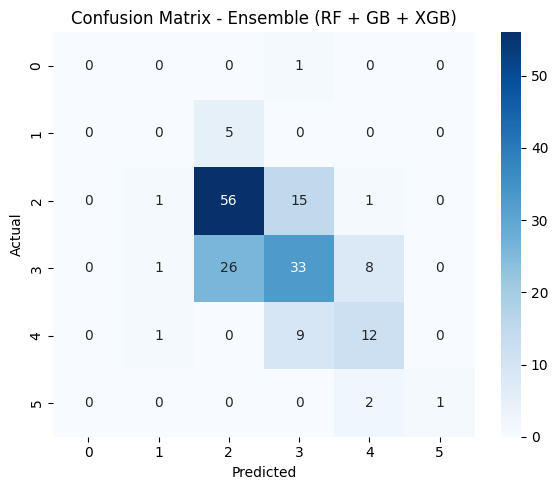

In [26]:
# =====================================================
#  12. VISUALISASI CONFUSION MATRIX
# =====================================================
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Ensemble (RF + GB + XGB)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Bagian kode ini digunakan untuk **menampilkan visualisasi hasil prediksi model ensemble** dalam bentuk *confusion matrix* agar lebih mudah dianalisis. Setelah model Ensemble (gabungan Random Forest, Gradient Boosting, dan XGBoost) melakukan prediksi, hasil *confusion matrix* yang telah dihitung divisualisasikan menggunakan **heatmap** dari library `seaborn`.

Heatmap ini menampilkan jumlah prediksi benar dan salah pada setiap kelas dengan pewarnaan yang semakin gelap seiring meningkatnya nilai. Sumbu **X** menunjukkan *predicted labels* (hasil prediksi model), sedangkan sumbu **Y** menunjukkan *actual labels* (label sebenarnya). Judul, label sumbu, serta tata letak dibuat rapi menggunakan `plt.title()`, `plt.xlabel()`, `plt.ylabel()`, dan `plt.tight_layout()`. Visualisasi ini membantu dalam melihat pola kesalahan klasifikasi dan seberapa baik model dalam membedakan setiap kelas.


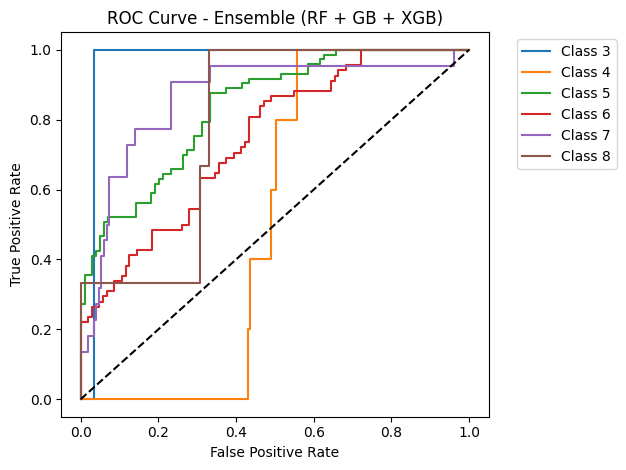

In [27]:
# =====================================================
#  13. ROC CURVE
# =====================================================
fpr, tpr = {}, {}
for i, cls in enumerate(np.unique(y_val)):
    fpr[cls], tpr[cls], _ = roc_curve((y_val == cls).astype(int), y_proba[:, i])
    plt.plot(fpr[cls], tpr[cls], label=f"Class {cls}")

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve - Ensemble (RF + GB + XGB)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Bagian kode ini digunakan untuk **menampilkan kurva ROC (Receiver Operating Characteristic)** dari model ensemble yang terdiri atas Random Forest, Gradient Boosting, dan XGBoost. Kurva ROC digunakan untuk mengevaluasi kemampuan model dalam membedakan antara kelas positif dan negatif pada setiap kategori.

Langkah pertama, untuk setiap kelas yang ada pada data uji (`y_val`), dilakukan perhitungan **false positive rate (FPR)** dan **true positive rate (TPR)** menggunakan fungsi `roc_curve()`. Nilai probabilitas hasil prediksi (`y_proba[:, i]`) digunakan untuk menghitung sejauh mana model mampu mengidentifikasi kelas tersebut dengan benar.

Kemudian, setiap kurva ROC untuk masing-masing kelas digambarkan dengan `plt.plot()`, sedangkan garis diagonal `plt.plot([0,1],[0,1],'k--')` menunjukkan garis acuan model acak (tanpa kemampuan klasifikasi). Sumbu **X** mewakili *false positive rate*, dan sumbu **Y** mewakili *true positive rate*. Judul, label, serta legenda ditambahkan agar visualisasi lebih informatif. Kurva ROC yang semakin mendekati sudut kiri atas menunjukkan bahwa model memiliki performa klasifikasi yang semakin baik.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-3785061429.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')


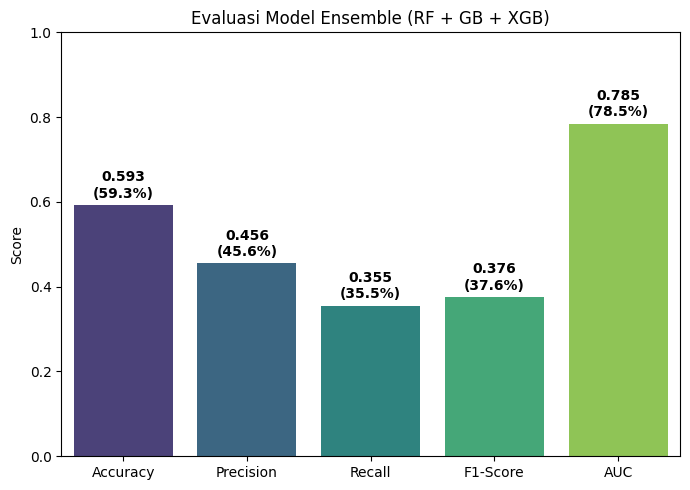

In [28]:
# =====================================================
#  14. NILAI EVALUASI
# =====================================================
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred, average='macro')
rec = recall_score(y_val, y_pred, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')

metrics = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1, 'AUC': auc_score}

plt.figure(figsize=(7,5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')
plt.title("Evaluasi Model Ensemble (RF + GB + XGB)")
plt.ylabel("Score")
plt.ylim(0, 1)
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.01, f"{v:.3f}\n({v*100:.1f}%)",
             ha='center', va='bottom', fontweight='bold', fontsize=10)
plt.tight_layout()
plt.show()


Bagian kode ini digunakan untuk **menghitung dan memvisualisasikan hasil evaluasi performa model ensemble** (gabungan Random Forest, Gradient Boosting, dan XGBoost) menggunakan beberapa metrik utama.

Pertama, dilakukan perhitungan nilai **Accuracy**, **Precision**, **Recall**, dan **F1-Score** dengan fungsi dari `sklearn.metrics`. Semua metrik tersebut dihitung menggunakan pendekatan **macro average**, yaitu rata-rata dari tiap kelas tanpa memperhatikan proporsi jumlah datanya. Selain itu, nilai **AUC (Area Under Curve)** yang sebelumnya telah dihitung juga dimasukkan sebagai salah satu indikator performa model.

Selanjutnya, semua nilai metrik disimpan dalam bentuk dictionary `metrics` agar mudah divisualisasikan. Kemudian, dengan menggunakan `seaborn.barplot()`, dibuat diagram batang untuk menunjukkan perbandingan nilai tiap metrik. Sumbu **X** menampilkan jenis metrik, sedangkan sumbu **Y** menunjukkan nilai performanya (antara 0 hingga 1). Setiap batang juga diberi label berupa nilai numerik dan persentasenya untuk memperjelas hasil evaluasi.

Visualisasi ini memberikan gambaran menyeluruh tentang seberapa baik model ensemble dalam mengklasifikasikan data, di mana semakin tinggi nilai pada setiap metrik, semakin baik pula performa model tersebut.


In [29]:
# =====================================================
#  15. CROSS VALIDATION
# =====================================================
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(ensemble, X_scaled, y, cv=cv, scoring='accuracy')
print(f"\nRata-rata akurasi dengan 10-Fold CV: {cv_scores.mean():.4f}")


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(



Rata-rata akurasi dengan 10-Fold CV: 0.6466


Bagian kode ini berfungsi untuk **mengevaluasi kestabilan dan keandalan performa model ensemble** menggunakan teknik **cross validation**, tepatnya **Stratified K-Fold Cross Validation**.

Pertama, objek `StratifiedKFold` dibuat dengan parameter `n_splits=10`, yang berarti data akan dibagi menjadi **10 lipatan (fold)**. Setiap lipatan akan digunakan secara bergantian sebagai data uji, sementara lipatan lainnya menjadi data latih. Parameter `shuffle=True` memastikan bahwa data diacak sebelum dibagi, dan `random_state=42` digunakan agar hasilnya konsisten saat dijalankan ulang. Teknik *stratified* dipilih agar **proporsi kelas tetap seimbang pada setiap lipatan**, terutama penting jika dataset memiliki distribusi kelas yang tidak seimbang.

Selanjutnya, fungsi `cross_val_score()` digunakan untuk menghitung nilai akurasi pada setiap lipatan cross validation. Nilai hasil evaluasi dari seluruh lipatan disimpan di `cv_scores`. Terakhir, kode menghitung **rata-rata akurasi dari 10 percobaan tersebut** dengan `cv_scores.mean()`, yang kemudian ditampilkan dalam format empat angka di belakang koma.

Hasil ini memberikan gambaran umum tentang **konsistensi performa model ensemble** di berbagai subset data. Semakin tinggi dan stabil nilai rata-rata akurasi, semakin baik pula kemampuan generalisasi model terhadap data baru.


In [30]:
# =====================================================
#  16. PREDIKSI DATA TESTING
# =====================================================
prediksi_quality = ensemble.predict(X_test_scaled)

hasil_prediksi = pd.DataFrame({
    'Id': test['Id'],
    'quality': prediksi_quality
})

hasil_prediksi.to_csv('hasil_prediksi.csv', index=False)
print("\n✅ File hasil_prediksi_")
hasil_prediksi.head()


✅ File hasil_prediksi_


,Id,quality
0,222,5
1,1514,6
2,417,5
3,754,5
4,516,5


Bagian kode ini merupakan **tahap akhir dari proses klasifikasi**, yaitu melakukan **prediksi pada data testing** menggunakan model terbaik yang telah dibangun sebelumnya, yaitu **model ensemble (gabungan RF, GB, dan XGB)**.

Pertama, baris `prediksi_quality = ensemble.predict(X_test_scaled)` menjalankan proses prediksi terhadap data uji (`X_test_scaled`) yang sebelumnya telah melalui tahap **standarisasi (scaling)** agar memiliki skala fitur yang seragam dengan data latih. Hasil prediksi tersebut berupa label kelas (misalnya tingkat kualitas anggur atau kategori lainnya) yang disimpan dalam variabel `prediksi_quality`.

Selanjutnya, hasil prediksi tersebut dikombinasikan dengan kolom **‘Id’** dari dataset uji (`test['Id']`) menggunakan fungsi `pd.DataFrame()`, sehingga terbentuk DataFrame baru bernama `hasil_prediksi` yang berisi dua kolom: **‘Id’** dan **‘quality’**. Struktur ini umum digunakan dalam pelaporan hasil prediksi atau pengumpulan submission pada kompetisi data.

Kemudian, data hasil prediksi disimpan ke dalam file CSV menggunakan `to_csv('hasil_prediksi.csv', index=False)`. Parameter `index=False` memastikan bahwa kolom indeks tidak ikut disimpan ke dalam file. Setelah proses penyimpanan selesai, pesan konfirmasi dicetak untuk memastikan keberhasilan ekspor, dan `hasil_prediksi.head()` digunakan untuk menampilkan lima baris pertama dari hasil prediksi sebagai cuplikan output.

Dengan demikian, bagian ini berfungsi untuk **menghasilkan file akhir berisi hasil klasifikasi model ensemble pada data uji**, yang dapat digunakan untuk evaluasi lebih lanjut atau dikirim sebagai hasil akhir penelitian atau kompetisi.
